In [58]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "iveeaten3223times/massive-yahoo-finance-dataset",
    "stock_details_5_years.csv",
)
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [59]:
import numpy as np
from random import choice
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def prepare_dataset(df, window_size, test_size=0.2, leave_test_company=True, test_company=None):
    df = df.sort_values(by=["Company", "Date"])

    companies = df["Company"].unique()
    if leave_test_company: # for visualising its stock prediction later
        if not test_company: test_company = choice(companies) 
        query = df[df["Company"] == test_company]
        test_company_data = {"name":test_company, "data":query["Close"].values}
        df = df.drop(query.index)
        
    df.reset_index()
    
    X = []
    Y = []

    i = 0
    while i < len(df):
        print(f"{i/len(df)*100}% of the dataset was processed.")
        curr_company = df.iloc[[i]]["Company"].item()
        while (i+WINDOW_SIZE) < len(df) and df.iloc[[i+WINDOW_SIZE]]["Company"].item() == curr_company:
            window = df.iloc[i:i+WINDOW_SIZE]["Close"].values.reshape(-1, 1)
            output = df.iloc[[i+WINDOW_SIZE]]["Close"].item()
            scaler = MinMaxScaler()
            window = scaler.fit_transform(window)
            X.append(window)
            Y.append(scaler.transform([[output]]).item())
            i += 1
        while i < len(df) and df.iloc[[i]]["Company"].item() == curr_company:
            i += 1

    X = np.array(X).squeeze(-1)
    Y = np.array(Y)

    train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=test_size)
    
    if leave_test_company:
        return train_x, test_x, train_y, test_y, test_company_data
    else:
        return train_x, test_x, train_y, test_y

WINDOW_SIZE = 256
train_x, test_x, train_y, test_y, test_company_data = prepare_dataset(df, WINDOW_SIZE)


0.0% of the dataset was processed.
0.2090728996317126% of the dataset was processed.
0.4181457992634252% of the dataset was processed.
0.6272186988951378% of the dataset was processed.
0.8362915985268504% of the dataset was processed.
0.9604390198502918% of the dataset was processed.
1.1695119194820045% of the dataset was processed.
1.378584819113717% of the dataset was processed.
1.5876577187454297% of the dataset was processed.
1.7967306183771423% of the dataset was processed.
2.005803518008855% of the dataset was processed.
2.2148764176405678% of the dataset was processed.
2.4239493172722804% of the dataset was processed.
2.633022216903993% of the dataset was processed.
2.8420951165357056% of the dataset was processed.
3.051168016167418% of the dataset was processed.
3.260240915799131% of the dataset was processed.
3.4693138154308434% of the dataset was processed.
3.678386715062556% of the dataset was processed.
3.8874596146942686% of the dataset was processed.
4.081907383032188% of

In [60]:
import torch
import torch.nn as nn

HIDDEN_SIZE = 512

class Trader(nn.Module):
    def __init__(self, window_size, hidden_size):
        super(Trader, self).__init__()
        self.window_size = window_size
        self.hidden_size = hidden_size
        self.LSTM = nn.LSTM(self.window_size, self.hidden_size, batch_first=True)
        self.do = nn.Dropout(0.1)
        self.fc = nn.Linear(self.hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(size=(1, x.size(0), self.hidden_size), requires_grad=True)
        c0 = torch.zeros(size=(1, x.size(0), self.hidden_size), requires_grad=True)
        x, _ = self.LSTM(x)
        x = self.do(x)
        x = self.fc(x)
        return x
        
loss_fn = nn.MSELoss()
lr = 1e-5
model = Trader(WINDOW_SIZE, HIDDEN_SIZE)
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

In [61]:
from torch.utils.data import TensorDataset, DataLoader

train_x = torch.Tensor(train_x)
train_y = torch.Tensor(train_y)

train_dataset = TensorDataset(train_x,train_y) 
train_dataloader = DataLoader(train_dataset, batch_size=64, drop_last=True)


test_x = torch.Tensor(test_x)
test_y = torch.Tensor(test_y)

test_dataset = TensorDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=64, drop_last=True)

In [62]:
num_epochs = 100

best_eval_loss = 1
patience = 5
harmful_epochs = 0

for epoch in range(1, num_epochs+1):
    print(f"Started epoch #{epoch}.")

    running_loss = 0
    instances_count = 0
    
    for x,y in train_dataloader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y.unsqueeze(-1))
        running_loss += loss.item()
        instances_count += 1
        loss.backward()
        optimizer.step()

    print(f"Train loss: {running_loss/instances_count}")

    running_loss = 0
    instances_count = 0
    for x,y in test_dataloader:
        with torch.no_grad():
            output = model(x)
            loss = loss_fn(output, y.unsqueeze(-1))
        running_loss += loss.item()
        instances_count += 1
    eval_loss = running_loss/instances_count
    print(f"Test loss: {eval_loss}")
    if eval_loss <= best_eval_loss: 
        best_eval_loss = eval_loss
        harmful_epochs = 0
    else:
        harmful_epochs += 1

    if harmful_epochs > patience:
        print("Ran out of patience.")
        break

Started epoch #1.
Train loss: 0.021050873778782946
Test loss: 0.006984071440017758
Started epoch #2.
Train loss: 0.00570944364012474
Test loss: 0.0043908528528721034
Started epoch #3.
Train loss: 0.004350868169016153
Test loss: 0.003711253478422591
Started epoch #4.
Train loss: 0.0038805261055132336
Test loss: 0.0033926192225883366
Started epoch #5.
Train loss: 0.0036407384625866644
Test loss: 0.0032387081503335202
Started epoch #6.
Train loss: 0.0034984926041512704
Test loss: 0.0031243322865600913
Started epoch #7.
Train loss: 0.0034048730381716786
Test loss: 0.003060189033783422
Started epoch #8.
Train loss: 0.0033437627594486824
Test loss: 0.002988158156573047
Started epoch #9.
Train loss: 0.0032978293368136655
Test loss: 0.0029585118225073257
Started epoch #10.
Train loss: 0.0032571394467688516
Test loss: 0.002931416080123135
Started epoch #11.
Train loss: 0.003228589418479122
Test loss: 0.0028891382136778084
Started epoch #12.
Train loss: 0.003207991856077787
Test loss: 0.00287733

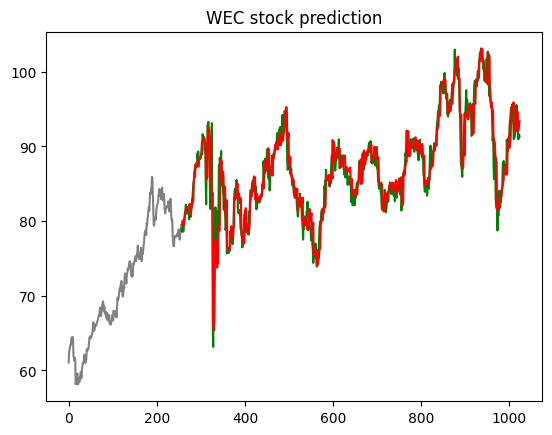

In [92]:
from matplotlib import pyplot as pp

def test_company_predict(test_company_data, predict_range=WINDOW_SIZE):
    time = np.arange(len(test_company_data['data']))
    actual = test_company_data['data'].tolist()
    predicted = []
    model.eval()
    peek_interval = 5 # peek into the real data every 5 time steps
    while len(predicted) < predict_range: # predict window_size (= 256) time steps
        window = actual[len(predicted):WINDOW_SIZE+len(predicted):]
        no_peek = 0 # how many time steps did we predict yet without peeking into the real data
        while no_peek != peek_interval - 1:
            scaler = MinMaxScaler()
            window_scaled = scaler.fit_transform(np.array(window).reshape(-1, 1))
            with torch.no_grad():
                output = model(torch.Tensor(window_scaled).unsqueeze(0).squeeze(-1))
            output = scaler.inverse_transform(output)
            predicted.append(output.item())
            window.pop(0)
            window += [output.item()]
            no_peek += 1
            
    pp.title(f"{test_company_data['name']} stock prediction")
    pp.plot(time[:WINDOW_SIZE], actual[:WINDOW_SIZE], color='gray')
    pp.plot(time[WINDOW_SIZE:WINDOW_SIZE + predict_range], actual[WINDOW_SIZE:WINDOW_SIZE + predict_range], color='green')
    pp.plot(time[WINDOW_SIZE:WINDOW_SIZE + len(predicted)], predicted, color='red')
    pp.show()

test_company_predict(test_company_data, 3*WINDOW_SIZE)


In [66]:
torch.save(model.state_dict(), "LSTM_Trader.pt")

In [67]:
test_company_data['name']

'WEC'